# Spooky Author Prediction 
(https://www.kaggle.com/c/spooky-author-identification/data) **to be removed...**

### 1. Data and Problem

- **Dataset description**:

The dataset contains text from works of fiction written by spooky authors of the public domain: `Edgar Allan Poe`, `HP Lovecraft` and `Mary Shelley`.

- **Problem statement**:

Given the training dataset, objective is to design a model that accurately predicts the author of the sentences in the test dataset.

In [76]:
# basic imports
import re
import string
import seaborn as sns
import numpy as np
from scipy.sparse import coo_matrix

# nlp imports
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd
import sent2vec

# basic classifiers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, linear_model, metrics, naive_bayes, svm

# goodsie classifiers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# specify torch to use gpu
print('number of CUDA devices: ',torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

number of CUDA devices:  1
Quadro P5000
cuda:0


### 2. Exploratory Data Analysis

**a) Load and check train data**

In [50]:
train_data = pd.read_csv("train.csv")
print(f'{train_data.shape} train data shape')

train_data.head(5)

(19579, 3) train data shape


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


**b) Count author frequencies in the dataset**

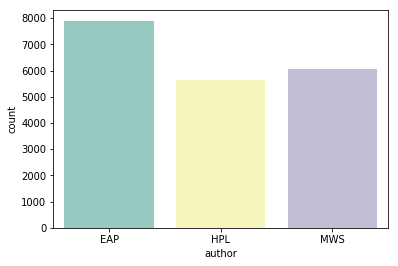

In [3]:
sns.countplot('author', data = train_data, palette="Set3")

As it does not make sense to do any further exploratory data analysis without pre-processing, we decided to move to `step-3` and revist `step-2` later.

### 3. Data Preprocessing

We have used the pre-processing techniques used throughout the course of the study group

- tokenize sentences
- remove stopwords
- remove numbers
- convert to lowercase
- lemmatizing (instead of `stemming`, as we had enough resources to cope with)

In [48]:
def get_X_and_y(raw_data):
    features = []
    labels = []
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stopwords = nltk.corpus.stopwords.words('english')

    for sentence_index in range(raw_data.shape[0]):
        sentence = raw_data.text[sentence_index]
        author = raw_data.author[sentence_index]

        # tokenize
        sentence_words = tokenizer.tokenize(sentence)

        # remove stopwords, covert to lowercase
        sentence_words = [word.lower() for word in sentence_words if word.lower() not in stopwords]

        # remove numbers
        words = [re.sub('[0-9]+', '', token) for token in sentence_words]

        # lemmatizing
        lemmatizer = WordNetLemmatizer()
        sentence_words = [lemmatizer.lemmatize(word) for word in sentence_words]

        features.append(' '.join(sentence_words))
        labels.append(author)
        
    return features, labels

In [51]:
train_features, train_labels = get_X_and_y(train_data)
print(f'extracted {len(train_features)} training data features and labels')

extracted 19579 training data features and labels


**Vectorizing using tf-idf vectorizer**:

In [66]:
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(train_features)

**Splitting the data into train and validation sets**:

In [67]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_vectors, train_labels, test_size=0.2, shuffle=True)
print(f'training dataset size: {X_train.shape}')
print(f'validation dataset size: {X_valid.shape}')

training dataset size: (15663, 22016)
validation dataset size: (3916, 22016)


### 4. Approaches

**a) Motivation**: Though our objective was essentially text classification, we discussed to experiment a bit with the representation/format of the dataset before trying out various classification methods

**b) Methods**:

- Logistic Regression (using tf-idf sentence vectors)

In [8]:
classifier = linear_model.LogisticRegression(C = 1.0)
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_valid)

print(f'logistic regression logloss: {metrics.log_loss(y_valid, predictions):0.4f}')

logistic regression logloss: 0.6125


- Naive Bayes (using tf-idf sentence vectors)

In [9]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_valid)

print(f'naive bayes logloss: {metrics.log_loss(y_valid, predictions):0.4f}')

naive bayes logloss: 0.5926


- Deep Neural Network (using tf-idf sentence vectors)

In [19]:
word_to_ix = {}
for sentence in train_features:
    for word in sentence.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

author_to_ix = {'EAP': 0, 'HPL': 1, 'MWS': 2}
print(len(word_to_ix), len(author_to_ix))

22040 3


In [20]:
def make_bow_vector(sentence, word_to_ix):
    vec = np.zeros(len(word_to_ix))
    for word in sentence.split():
        vec[word_to_ix[word]] += 1
    return vec

def make_target(label, author_to_ix):
    return torch.LongTensor([author_to_ix[label]])

In [41]:
class BoWClassifier(nn.Module):

    def __init__(self, num_labels, vocab_size, n_hidden1, n_hidden2):
        super(BoWClassifier, self).__init__()
        self.hidden1 = nn.Linear(vocab_size, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, num_labels)
        
    def forward(self, x_val):
        x = Variable(x_val, requires_grad=False)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.log_softmax(self.out(x), dim=1)
        return x

In [88]:
VOCAB_SIZE = len(word_to_ix)
HIDDEN1 = 1024
HIDDEN2 = 1024
NUM_LABELS = 3

model = BoWClassifier(NUM_LABELS, VOCAB_SIZE, HIDDEN1, HIDDEN2)
optimizer = optim.Adam(model.parameters())

epochs = 1
batch_size = 1000
num_batches = int(len(train_features) * 0.8) // batch_size
critize = nn.CrossEntropyLoss()

X_train = train_features[:int(len(train_features) * 0.8)]
y_train = train_labels[:int(len(train_features) * 0.8)]

X_valid = train_features[int(len(train_features) * 0.8) + 1 :]
y_valid = train_labels[int(len(train_features) * 0.8) + 1 :]

print(f'{len(X_train)} training samples, {len(X_valid)} validation samples')

15663 training samples, 3915 validation samples


In [57]:
for epoch in range(epochs):
    losses = []
    for batch in range(num_batches):
        start, end = batch * batch_size, (batch + 1) * batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]
        
        X_batch = np.array([make_bow_vector(sentence, word_to_ix) for sentence in X_batch])
        y_batch = np.array([make_target(author, author_to_ix) for author in y_batch])
        X_batch = torch.from_numpy(X_batch).float()
        y_batch = Variable(torch.from_numpy(y_batch), requires_grad=False)
        
        model.zero_grad()
        output_fw = model.forward(X_batch)

        loss = critize(output_fw, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.mean())

    X_batch = X_valid
    y_batch = y_valid
    X_batch = np.array([make_bow_vector(sentence, word_to_ix) for sentence in X_batch])
    y_batch = np.array([make_target(author, author_to_ix) for author in y_batch])
    X_batch = torch.from_numpy(X_batch).float()
    y_batch = Variable(torch.from_numpy(y_batch), requires_grad=False)
    
    model.zero_grad()
    output_fw = model.forward(X_batch)
    validation_loss = critize(output_fw, y_batch)
    
    print(f'deep neural network loss:  {validation_loss:4f}')

deep neural network loss:  0.475535


_____________________________________________________

In [84]:
train_features = list(train_data.text.values)
train_labels = list(train_data.author.values)

X_train = train_features[:int(len(train_features) * 0.8)]
y_train = train_labels[:int(len(train_features) * 0.8)]

X_valid = train_features[int(len(train_features) * 0.8) + 1 :]
y_valid = train_labels[int(len(train_features) * 0.8) + 1 :]

In [85]:
model = sent2vec.Sent2vecModel()
model.load_model('torontobooks_bigrams.bin')
train_embeddings = model.embed_sentences(X_train)

model = sent2vec.Sent2vecModel()
model.load_model('torontobooks_bigrams.bin')
valid_embeddings = model.embed_sentences(X_valid)

In [86]:
print(f'sentence embeddings of dimension {len(train_embeddings[0])}')

sentence embeddings of dimension 700


- Logistic regression (using sent2vec)

In [87]:
classifier = linear_model.LogisticRegression(C = 1.0)
classifier.fit(train_embeddings, y_train)
predictions = classifier.predict_proba(valid_embeddings)

print(f'logistic regression logloss: {metrics.log_loss(y_valid, predictions):0.4f}')

logistic regression logloss: 0.7818


- Support vector machines (using sent2vec)

In [78]:
classifier = svm.SVC(probability=True)
classifier.fit(train_embeddings, y_train)
predictions = classifier.predict_proba(valid_embeddings)

In [80]:
print(f'SVM logloss: {metrics.log_loss(y_valid, predictions):0.4f}')

SVM logloss: 0.7001


- deep neural network (recurrent, using sent2vec)

In [92]:
class LSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (Variable(torch.zeros(1, 1, self.hidden_dim)),
                Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        x = embeds.view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.hidden2label(lstm_out[-1])
        log_probs = F.log_softmax(y)
        return log_probs

In [115]:
def validate(model, loss_function, name ='validation'):
    model.eval()
    avg_loss = 0.0

    for index in range(len(X_valid)):
        sent = X_valid[index]
        label = y_valid[index]
        model.hidden = model.init_hidden()
        sent = Variable(torch.LongTensor([word_to_ix[w] for w in sent.split()]))
        label = Variable(torch.LongTensor([author_to_ix[label]]))
        pred = model(sent)
        pred_label = pred.data.max(1)[1].numpy()
        loss = loss_function(pred, label)
        avg_loss += loss.data[0]
    
    avg_loss /= len(X_valid)
    print(name + ' avg_loss:%g' % (avg_loss))

def train_epoch(model, loss_function, optimizer, epoch):
    model.train()
    
    avg_loss = 0.0

    for index in range(len(X_train)):
        sent = X_train[index]
        label = y_train[index]
        model.hidden = model.init_hidden()
        if sent is '':
            continue
            
        sent = Variable(torch.LongTensor([word_to_ix[w] for w in sent.split()]))
        label = Variable(torch.LongTensor([author_to_ix[label]]))
        pred = model(sent)
        pred_label = pred.data.max(1)[1].numpy()
        model.zero_grad()
        loss = loss_function(pred, label)
        avg_loss += loss.data[0]

        loss.backward()
        optimizer.step()
        
    avg_loss /= len(train_data)
    print('epoch: %d done! \n train avg_loss:%g'%(epoch, avg_loss))


def train():
    
    EMBEDDING_DIM = 75
    HIDDEN_DIM = 50
    EPOCH = 5
    best_dev_acc = 0.0
    model = LSTMClassifier(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                           vocab_size=VOCAB_SIZE, label_size=NUM_LABELS)
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    
    for epoch in range(EPOCH):
        train_epoch(model, loss_function, optimizer, epoch)
        validate(model, loss_function)
        

In [116]:
train_features, train_labels = get_X_and_y(train_data)

X_train = train_features[:int(len(train_features) * 0.8)]
y_train = train_labels[:int(len(train_features) * 0.8)]

X_valid = train_features[int(len(train_features) * 0.8) + 1 :]
y_valid = train_labels[int(len(train_features) * 0.8) + 1 :]

train()

/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch: 0 done! 
 train avg_loss:0.682957


/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


validation avg_loss:0.688963
epoch: 1 done! 
 train avg_loss:0.369792
validation avg_loss:0.628053
epoch: 2 done! 
 train avg_loss:0.200964
validation avg_loss:0.685976
epoch: 3 done! 
 train avg_loss:0.103686
validation avg_loss:0.827851
epoch: 4 done! 
 train avg_loss:0.054936
validation avg_loss:1.00635


### 5. Experimental Results

|                      | logistic regression | naive bayes (multinomial) | deep neural network (feed forward) |
| :------------------: | :-----------------: | :-----------------------: | :-----------------: |
|       sent2vec       |                     |                           |                     |
|        tf-idf / BOW  |                     |                           |                     |

### 6. Conclusions